## Data Visualization

In [1]:
import pandas as pd

test_data = pd.read_csv('data/test.csv',names = ["class","title","body"])
train_data = pd.read_csv('data/train.csv',names = ["class","title","body"])

In [2]:
train_data = train_data.iloc[1:,:].reset_index().drop(['index'],axis=1)
test_data = test_data.iloc[1:,:].reset_index().drop(['index'],axis=1)

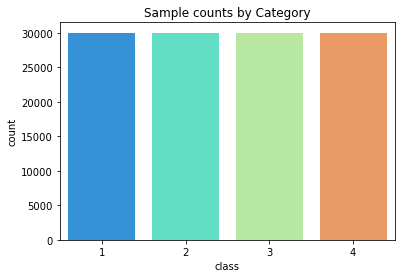

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='class',data=train_data, palette='rainbow')
plt.title('Sample counts by Category- Train Data')
plt.show()

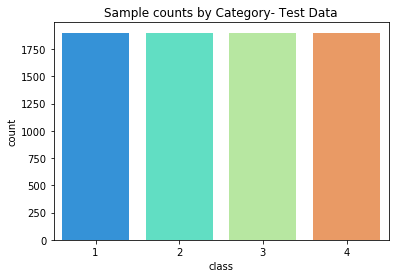

In [20]:
sns.countplot(x='class',data=test_data, palette='rainbow')
plt.title('Sample counts by Category- Test Data')
plt.show()

In [28]:
train_data['class']=='3'

0          True
1          True
2          True
3          True
4          True
          ...  
119995    False
119996    False
119997    False
119998    False
119999    False
Name: class, Length: 120000, dtype: bool

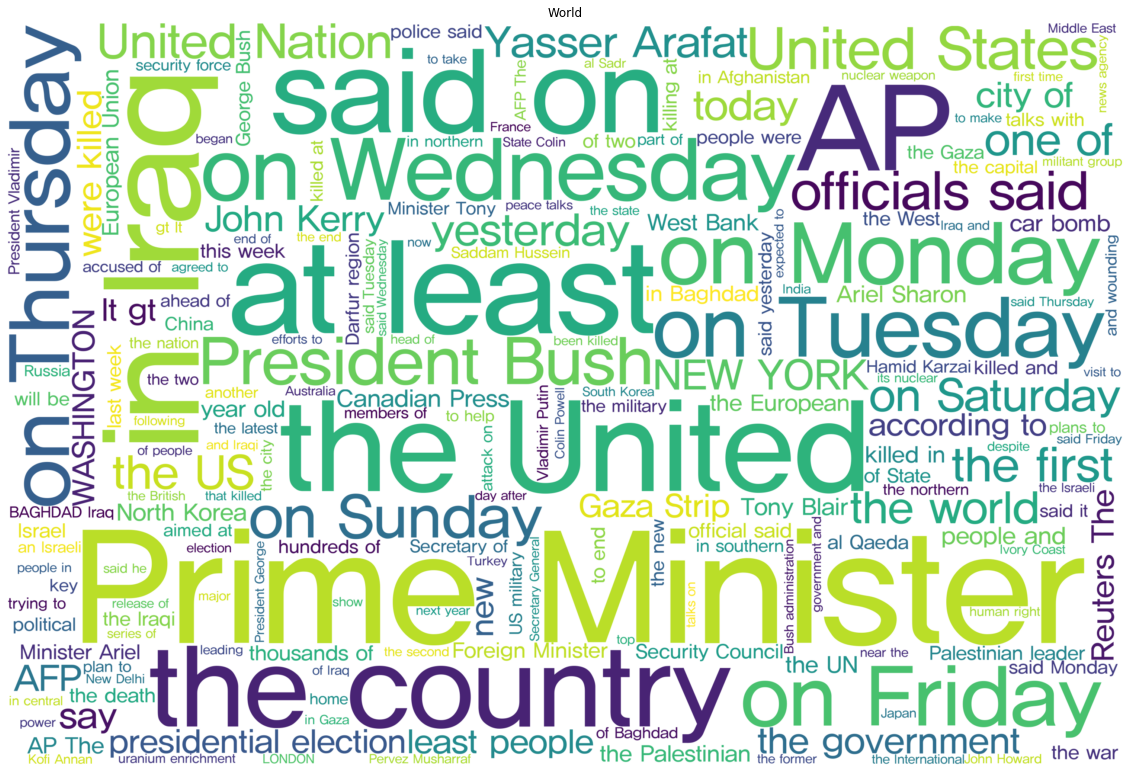

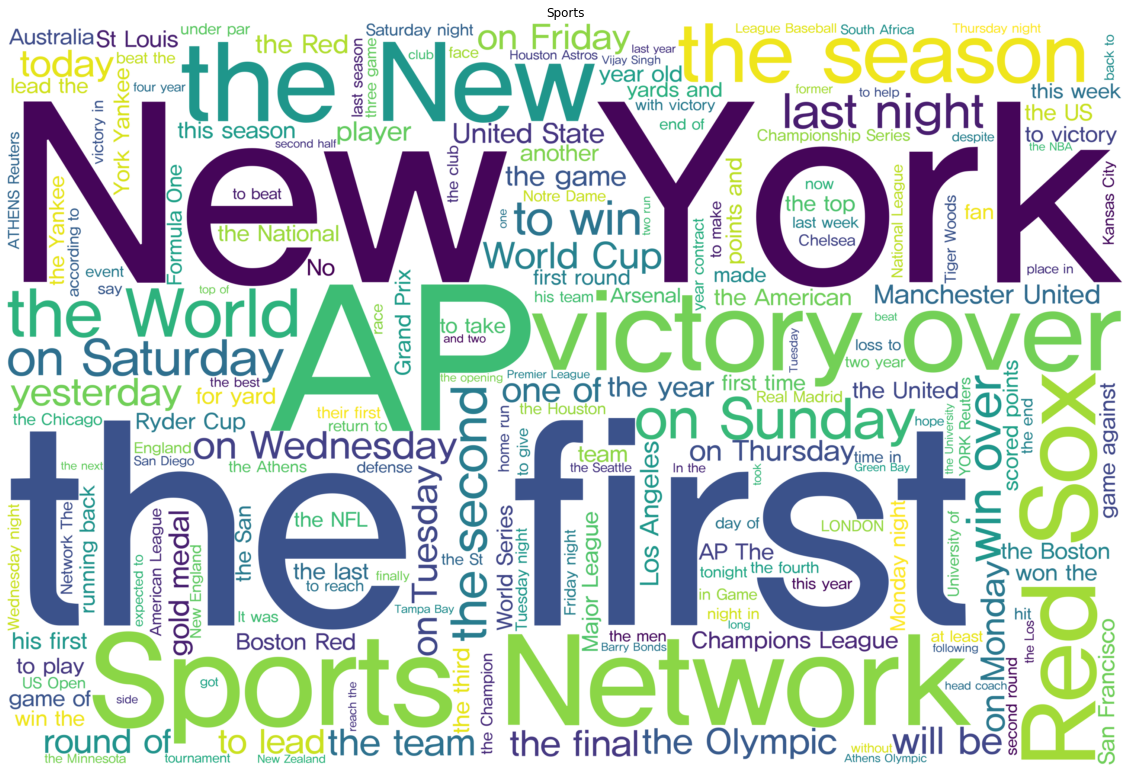

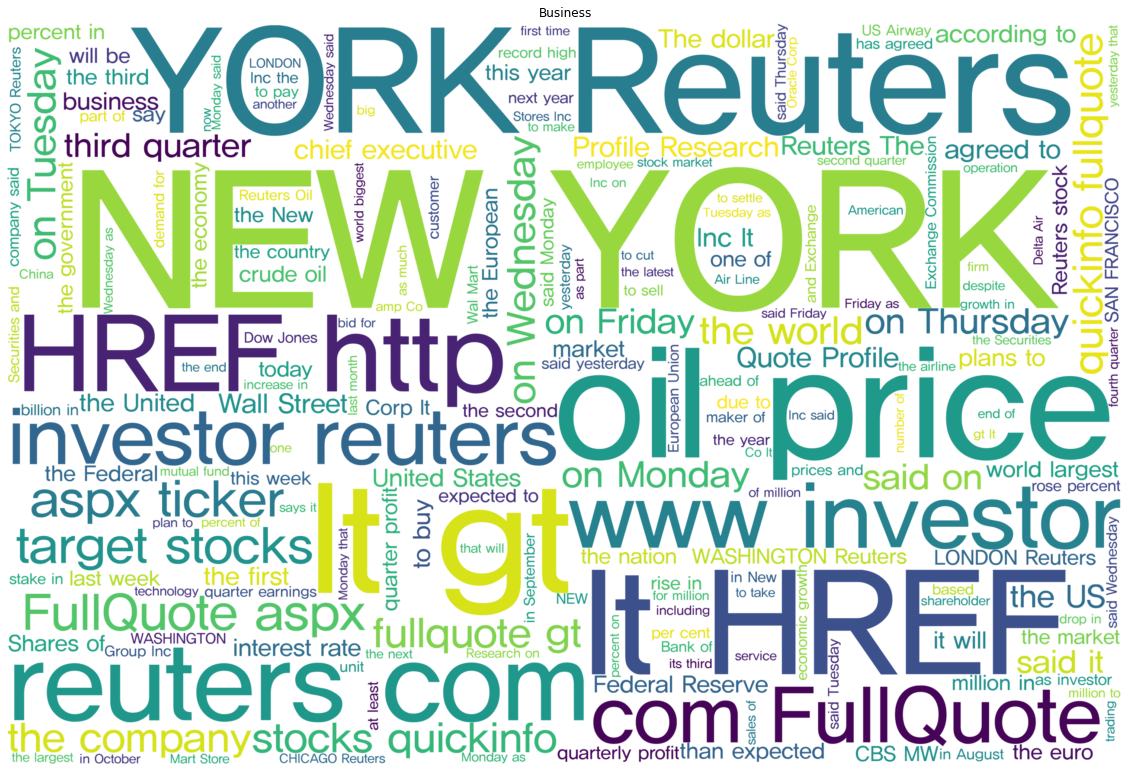

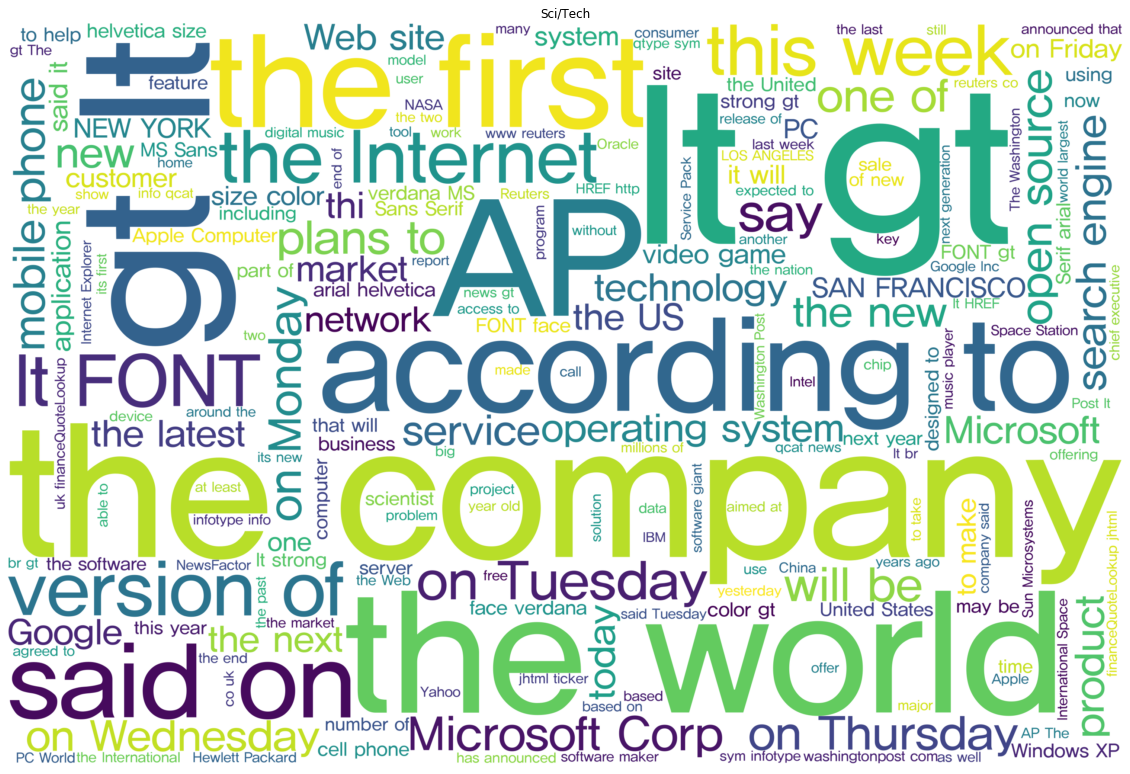

In [41]:
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
tt = ['World','Sports','Business','Sci/Tech']

for i in range(1,5):
    text = np.array(train_data['body'][train_data['class']==str(i)])
    text = ''.join(text)

    wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/윤고딕330.ttf', width = 3000, height = 2000, 
                          background_color = 'white',stopwords = stopwords).generate(text)
    fig = plt.figure(figsize = (20, 15))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.title(tt[i-1])
    plt.show()

## Data Preprocessing

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm

# nltk.download('stopwords')
# nltk.download('punkt')

In [2]:
def Preprocessing(txt):
    txt = str(txt).replace('\\',' ')
    
    #Tokenizer
    tokens = [word for sentence in nltk.sent_tokenize(txt)
              for word in nltk.word_tokenize(sentence)]
    
    #불필요한 앞 두단어 제거
    tokens = tokens[2:]
    
    #Non Alphabet 제거
    tokens = [word for word in tokens if word.isalpha()]
    
    #Stopwords 제거
    nltk.download('stopwords')
    stopword = stopwords.words('english')
    tokens = [word for word in tokens if word not in stopword]
    
    #Lowercase
    tokens = [word.lower() for word in tokens]
    
    #Stemming
    stemmer = PorterStemmer()
    tokens = [ stemmer.stem(word) for word in tokens]
    
    return tokens

In [14]:
import pandas as pd

test_data = pd.read_csv('data/test.csv',names = ["class","title","body"])
train_data = pd.read_csv('data/train.csv',names = ["class","title","body"])

In [15]:
train_data = train_data.iloc[1:,:].reset_index().drop(['index'],axis=1)
test_data = test_data.iloc[1:,:].reset_index().drop(['index'],axis=1)

In [16]:
train_data.head()

,class,title,body
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [5]:
train_X, train_Y = [],[]
test_X,  test_Y = [],[]

In [6]:
for i, row in tqdm(train_data.iterrows()):
    tokens = Preprocessing(row['title']) + Preprocessing(row['body'])
    
    train_X.append(tokens)
    train_Y.append(int(row['class'])-1)

120000it [06:19, 316.40it/s]


In [7]:
for i, row in tqdm(test_data.iterrows()):
    tokens = Preprocessing(row['title']) + Preprocessing(row['body'])
    
    test_X.append(tokens)
    test_Y.append(int(row['class'])-1)

7600it [00:24, 311.37it/s]


In [8]:
import json

train_data = {"train_X":train_X, "train_Y":train_Y }
test_data  = {"test_X":test_X, "test_Y":test_Y}

with open('traindata.json','w') as outfile:
    json.dump(train_data,outfile,indent=4)

with open('testdata.json','w') as outfile:
    json.dump(test_data,outfile,indent=4)

### Get Data from json

In [6]:
import json

with open('traindata.json') as jsonfile:
    traindata = json.load(jsonfile)

with open('testdata.json') as jsonfile:
    testdata = json.load(jsonfile)

In [7]:
train_X = traindata['train_X']
train_y = traindata['train_Y']

test_X = testdata['test_X']
test_y = testdata['test_Y']

In [8]:
from keras.utils import np_utils

train_y=np_utils.to_categorical(train_y, 4)
test_y=np_utils.to_categorical(test_y, 4)

Using TensorFlow backend.


In [ ]:
print(len(train_X),len(test_X))

## Modeling

In [ ]:
import numpy as np
embeddings_index = dict()

f = open('glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()

In [ ]:
gl_words = list(embeddings_index.keys())
len(gl_words)

In [ ]:
from keras.preprocessing.text import Tokenizer

n = 100000
tokenizer = Tokenizer(num_words = len(gl_words))
tokenizer.fit_on_texts(gl_words)

In [ ]:
embedding_matrix = np.zeros((n, 300)) 
for word, index in tokenizer.word_index.items():
    if index > n - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
print(embedding_matrix.shape)

In [ ]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 500
sequences = tokenizer.texts_to_sequences(train_X)
data = pad_sequences(sequences, maxlen=maxlen)
data.shape

## MLP

In [18]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Activation
from keras.layers import BatchNormalization,Dropout
from keras.layers import RNN, LSTM, GRU
from keras.layers import Bidirectional 
import tensorflow as tf
from keras import optimizers

In [19]:
#just random
model=Sequential()
model.add(Embedding(n, output_dim=300, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model.add(Flatten())
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4,activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

NameError: name 'n' is not defined

In [ ]:
result=model.fit(data, train_y, validation_split=0.3, batch_size=32, epochs = 20)

In [ ]:
import matplotlib.pyplot as plt
acc=result.history['accuracy']
val_acc=result.history['val_accuracy']
loss=result.history['loss']
val_loss=result.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,label='training acc')
plt.plot(epochs,val_acc,label='validation acc')
plt.title('training and validation accuracy (using Glove)')
plt.legend()
plt.figure()
plt.plot(epochs,loss,label='training loss')
plt.plot(epochs,val_loss,label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [ ]:
def train_and_validate(num_hlayers, dropout, epoch, learnrate):
    model_gl=Sequential()
    model_gl.add(Embedding(n, output_dim=300, input_length=maxlen, weights=[embedding_matrix], trainable=False))
    model_gl.add(Flatten())
    for i in range(num_hlayers): 
        model_gl.add(Dropout(dropout))
        model_gl.add(Dense(int(500/(i+1)),kernel_initializer='he_normal'))
        model_gl.add(BatchNormalization())
        model_gl.add(Activation('relu'))
    model_gl.add(Dense(4,activation='softmax')) 
    
    adam = optimizers.Adam(lr=learnrate)
    model_gl.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    mod = model_gl.fit(data, train_y, validation_split=0.3, batch_size=32, epochs = int(epoch), verbose=0)
    
    score = max(mod.history['val_accuracy'])
    
    return score

In [ ]:
from bayes_opt import BayesianOptimization

param={'num_hlayers':(1,6),
    'dropout':(0.5,0.75),
    'epoch':(10,30),
    'learnrate':(1e-4, 1e-1)}

optimizer = BayesianOptimization(
    f=train_and_validate,
    pbounds=param,
    random_state=0,
    verbose=2
)

optimizer.maximize(init_points=5,n_iter=10)

for i,res in enumerate(optimizer.res):
    print('Iteration {}: \n\t{}'.format(i,res))
print()
print()
print('Final result: ',optimizer.max)

In [ ]:
#Apply
mlp=Sequential()
mlp.add(Embedding(n, output_dim=300, input_length=maxlen, weights=[embedding_matrix], trainable=False))
mlp.add(Flatten())
for i in range(3): 
    mlp.add(Dropout(0.6)) #overfitting 방지
    mlp.add(Dense(int(500/(i+1)),kernel_initializer='he_normal'))
    mlp.add(BatchNormalization())
    mlp.add(Activation('relu'))
mlp.add(Dense(4,activation='softmax')) 
mlp.summary()

adam = optimizers.Adam(lr=0.0195)
mlp.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
result=mlp.fit(data, train_y, validation_split=0.3, batch_size=32, epochs = 27)

In [ ]:
import matplotlib.pyplot as plt
acc=result.history['accuracy']
val_acc=result.history['val_accuracy']
loss=result.history['loss']
val_loss=result.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,label='training acc')
plt.plot(epochs,val_acc,label='validation acc')
plt.title('training and validation accuracy (using Glove)')
plt.legend()
plt.figure()
plt.plot(epochs,loss,label='training loss')
plt.plot(epochs,val_loss,label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [ ]:
##Caculate Test Accuracy
from keras.preprocessing.sequence import pad_sequences

maxlen = 500
sequences = tokenizer.texts_to_sequences(test_X)
test_data = pad_sequences(sequences, maxlen=maxlen)
test_data.shape

In [ ]:
predict_ygl = mlp.predict(test_data)

In [ ]:
with tf.compat.v1.Session() :
    tf.argmax(predict_ygl,1).eval()
    argm = tf.equal(tf.argmax(test_y, 1), tf.argmax(predict_ygl, 1)) #맞으면 1
    print('accuracy:', tf.reduce_mean(tf.cast(argm, tf.float32)).eval()) #평균

## LSTM

In [ ]:
#Initally - random
rnn=Sequential()
rnn.add(Embedding(n, output_dim=300, input_length=maxlen, weights=[embedding_matrix], trainable=False))
rnn.add(LSTM(100, dropout=0.2, return_sequences=True))
rnn.add(LSTM(50, dropout=0.2))
rnn.add(Dense(4,activation='softmax')) 

rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn.summary()

In [ ]:
result=rnn.fit(data, train_y, validation_split=0.3, batch_size=32, epochs = 20)

In [ ]:
acc=result.history['accuracy']
val_acc=result.history['val_accuracy']
loss=result.history['loss']
val_loss=result.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,label='training acc')
plt.plot(epochs,val_acc,label='validation acc')
plt.title('training and validation accuracy (LSTM_initially)')
plt.legend()
plt.figure()
plt.plot(epochs,loss,label='training loss')
plt.plot(epochs,val_loss,label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [ ]:
def train_and_validate(num_hlayers, dropout, epoch):
    model_gl=Sequential()
    model_gl.add(Embedding(n, output_dim=300, input_length=maxlen, weights=[embedding_matrix], trainable=False))
    for i in range(num_hlayers): 
        model_gl.add(LSTM(int(100/(i+1)), dropout = dropout, return_sequences=True))
    model_gl.add(LSTM(int(100/(i+2)), dropout = dropout))
    model_gl.add(Dense(4,activation='softmax')) 
    
    model_gl.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    mod = model_gl.fit(data, train_y, validation_split=0.3, batch_size=32, epochs = int(epoch), verbose=0)
    
    score = max(mod.history['val_accuracy'])
    
    return score

In [ ]:
param={'num_hlayers':(1,2),
    'dropout':(0.5,0.7),
    'epoch':(15,25)}

optimizer = BayesianOptimization(
    f=train_and_validate,
    pbounds=param,
    random_state=0,
    verbose=2
)

optimizer.maximize(init_points=5,n_iter=10)

for i,res in enumerate(optimizer.res):
    print('Iteration {}: \n\t{}'.format(i,res))
print()
print()
print('Final result: ',optimizer.max)

In [ ]:
rnn=Sequential()
rnn.add(Embedding(n, output_dim=300, input_length=maxlen, weights=[embedding_matrix], trainable=False))
rnn.add(LSTM(100, dropout=0.6, return_sequences=True))
rnn.add(LSTM(50, dropout=0.6))
rnn.add(Dense(4,activation='softmax')) 
rnn.summary()

rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

result=rnn.fit(data, train_y, validation_split=0.3, batch_size=32, epochs = 18)

In [ ]:
acc=result.history['accuracy']
val_acc=result.history['val_accuracy']
loss=result.history['loss']
val_loss=result.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,label='training acc')
plt.plot(epochs,val_acc,label='validation acc')
plt.title('training and validation accuracy (LSTM)')
plt.legend()
plt.figure()
plt.plot(epochs,loss,label='training loss')
plt.plot(epochs,val_loss,label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [ ]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 500
sequences = tokenizer.texts_to_sequences(test_X)
test_data = pad_sequences(sequences, maxlen=maxlen)
test_data.shape

In [ ]:
predict_rnn = rnn.predict(test_data)

with tf.compat.v1.Session() :
    tf.argmax(predict_rnn,1).eval()
    argm = tf.equal(tf.argmax(test_y, 1), tf.argmax(predict_rnn, 1)) 
    print('accuracy:', tf.reduce_mean(tf.cast(argm, tf.float32)).eval())

## Bidirectional LSTM

In [ ]:
#Initally - random
rnn=Sequential()
rnn.add(Embedding(n, output_dim=300, input_length=maxlen, weights=[embedding_matrix], trainable=False))
rnn.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5)))
rnn.add(Dense(4,activation='softmax')) 
rnn.summary()

rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

result=rnn.fit(data, train_y, validation_split=0.3, batch_size=32, epochs = 20)

In [ ]:
acc=result.history['accuracy']
val_acc=result.history['val_accuracy']
loss=result.history['loss']
val_loss=result.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,label='training acc')
plt.plot(epochs,val_acc,label='validation acc')
plt.title('training and validation accuracy (Bidirectional LSTM_initially)')
plt.legend()
plt.figure()
plt.plot(epochs,loss,label='training loss')
plt.plot(epochs,val_loss,label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [ ]:
def train_and_validate(num_hlayers, dropout, rdrop, epoch):
    model_gl=Sequential()
    model_gl.add(Embedding(n, output_dim=300, input_length=maxlen, weights=[embedding_matrix], trainable=False))
    for i in range(num_hlayers): 
        model_gl.add(Bidirectional(LSTM(int(64/(i+1)), dropout = dropout, recurrent_dropout=rdrop, return_sequences=True))
    model_gl.add(Bidirectional(LSTM(int(64/(i+2)), dropout = dropout, recurrent_dropout=rdrop))
    model_gl.add(Dense(4,activation='softmax')) 
    
    model_gl.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    mod = model_gl.fit(data, train_y, validation_split=0.3, batch_size=32, epochs = int(epoch), verbose=0)
    
    score = max(mod.history['val_accuracy'])
    
    return score

In [ ]:
param={'num_hlayers':(1,2),
    'dropout':(0.5,0.7),
    'rdrop':(0.5,0.7),
    'epoch':(15,25)}

optimizer = BayesianOptimization(
    f=train_and_validate,
    pbounds=param,
    random_state=0,
    verbose=2
)

optimizer.maximize(init_points=5,n_iter=10)

for i,res in enumerate(optimizer.res):
    print('Iteration {}: \n\t{}'.format(i,res))
print()
print()
print('Final result: ',optimizer.max)

In [ ]:
rnn=Sequential()
rnn.add(Embedding(n, output_dim=300, input_length=maxlen, weights=[embedding_matrix], trainable=False))
rnn.add(Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
rnn.add(Bidirectional(LSTM(32, dropout=0.5, recurrent_dropout=0.5)))
rnn.add(Dense(4,activation='softmax')) 
rnn.summary()

rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

result=rnn.fit(data, train_y, validation_split=0.3, batch_size=32, epochs = 16)

In [ ]:
acc=result.history['accuracy']
val_acc=result.history['val_accuracy']
loss=result.history['loss']
val_loss=result.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,label='training acc')
plt.plot(epochs,val_acc,label='validation acc')
plt.title('training and validation accuracy (Bidirectional LSTM)')
plt.legend()
plt.figure()
plt.plot(epochs,loss,label='training loss')
plt.plot(epochs,val_loss,label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [ ]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 500
sequences = tokenizer.texts_to_sequences(test_X)
test_data = pad_sequences(sequences, maxlen=maxlen)
test_data.shape

In [ ]:
predict_rnn = rnn.predict(test_data)

with tf.compat.v1.Session() :
    tf.argmax(predict_rnn,1).eval()
    argm = tf.equal(tf.argmax(test_y, 1), tf.argmax(predict_rnn, 1)) 
    print('accuracy:', tf.reduce_mean(tf.cast(argm, tf.float32)).eval()) 

## GRU

In [ ]:
rnn=Sequential()
rnn.add(Embedding(n, output_dim=300, input_length=maxlen, weights=[embedding_matrix], trainable=False))
rnn.add(GRU(100, dropout=0.5, return_sequences=True))
rnn.add(GRU(50, dropout=0.5))
rnn.add(Dense(4,activation='softmax')) 

rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn.summary()

result=rnn.fit(data, train_y, validation_split=0.3, batch_size=32, epochs = 18)

In [ ]:
acc=result.history['accuracy']
val_acc=result.history['val_accuracy']
loss=result.history['loss']
val_loss=result.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,label='training acc')
plt.plot(epochs,val_acc,label='validation acc')
plt.title('training and validation accuracy (GRU)')
plt.legend()
plt.figure()
plt.plot(epochs,loss,label='training loss')
plt.plot(epochs,val_loss,label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [ ]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 500
sequences = tokenizer.texts_to_sequences(test_X)
test_data = pad_sequences(sequences, maxlen=maxlen)
test_data.shape

In [ ]:
predict_rnn = rnn.predict(test_data)

with tf.compat.v1.Session() :
    tf.argmax(predict_rnn,1).eval()
    argm = tf.equal(tf.argmax(test_y, 1), tf.argmax(predict_rnn, 1))
    print('accuracy:', tf.reduce_mean(tf.cast(argm, tf.float32)).eval()) 